# Mini BERT 만들기 프로젝트

`vocab size=8000`, 전체 파라미터 1M인 mini 트랜스포머 양방향 인코더 표현(BERT) 모델을 구축하여 10에폭(epoch) 학습시켜봅니다.

In [ ]:
# 패키지 로드
import pandas
import matplotlib
import json
import re

## 토크나이저(Tokenizer)

한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델을 만든다.

In [ ]:
# sentencepiece 모델 생성: 실행시 """ 삭제
!pip install sentencepiece
import sentencepiece as spm
import os
"""
corpus_file = os.getenv('HOME')+'/aiffel/AIFFEL_going_deeper/19-21 bert_pretrain/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰
"""

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.9 MB/s eta 0:00:00


'\ncorpus_file = os.getenv(\'HOME\')+\'/aiffel/AIFFEL_going_deeper/19-21 bert_pretrain/data/kowiki.txt\'\nprefix = \'ko_8000\'\nvocab_size = 8000\n\nspm.SentencePieceTrainer.train(\n    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +\n    " --model_type=bpe" +\n    " --max_sentence_length=999999" + # 문장 최대 길이\n    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)\n    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)\n    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)\n    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)\n    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰\n'

In [ ]:
# 토크나이저
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Data/BERT/'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{data_dir}/ko_8000.model")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


True

In [ ]:
# 토크나이저 사전 확인: 특수 token 7개를 제외한 token 출력
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        token = vocab.id_to_piece(id)
        vocab_list.append(token)

print(vocab_list)
len(vocab_list)

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다', '었다', '▁지', '▁수', '▁19', '▁가', '▁시', '▁20', '▁기', '▁전', '▁아', '▁하', '▁있다', '▁다', '▁제', '했다', '하였', '▁일', '▁한', '▁중', '▁정', '▁주', '하는', '▁것', '▁자', '▁공', '▁인', '되었다', '▁경', '▁위', '▁유', '▁보', '하고', '▁3', '▁등', '▁부', '하였다', '▁조', '하여', '▁미', '▁동', '▁선', '▁나', '으며', '▁모', '▁연', '▁영', '▁의', '▁오', '▁마', '에는', '▁발', '▁소', '한다', '▁고', '▁개', '▁201', '▁구', '▁세', '▁도', '▁상', '▁비', '▁스', '▁국', '▁서', '▁후', '▁여', '▁200', '▁때', '▁4', '▁성', '▁해', '▁관', '▁있는', '▁신', '▁프', '▁대한', '부터', '▁5', '▁방', '▁또', '지만', '▁(', '▁역', '되어', '▁않', '▁만', '▁"', '▁장', '▁바', '까지', '▁무', '▁남', '▁통', '▁현', '▁교', '▁같', '에게', '▁내', '학교', '▁문', '▁출', '▁거', '▁포', '▁결', '된다', '▁《', '적인', '이라', '▁6', '▁우', '적으로', '▁불', '▁원', '▁최', '▁10', '▁진', '▁생', '▁작', '▁어', '▁당', '국의', '▁노', '▁강', '▁알', '▁반', '▁7', '▁8', '▁계', '▁따', '▁파', '▁분', '▁없', '▁받', '▁말', '면서', '들이', 'or', '되었', '▁사용', "▁'", '▁두', '▁실', '에서는', '▁리', '들은', '▁명', '▁함', '▁단', '▁이후', '00', '하기', '▁예', '년에', '),',

8000

## 데이터 전처리

### 마스크(mask) 만들기

BERT의 마스크 처리 언어 모델링(MLM)에 필요한 빈칸을 만든다.학습 데이터 전체 토큰의 15% 정도 만들되, 이 중 80%는 빈칸(`[MASK]`) 토큰, 10%는 무작위 토큰, 나머지 10%는 원래의 토큰을 사용한다.

In [ ]:
# 사전훈련 데이터 마스킹 함수

import random
import copy

def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    BERT 사전 훈련을 위한 Masked Language Model 생성

    :param tokens: 토큰화된 문장의 토큰 목록
    :param mask_cnt: 마스킹할 토큰의 수 (전체 토큰의 15%)
    :param vocab_list: 단어 사전 리스트, 무작위 토큰 선택에 사용
    :return:
        - tokens: 마스킹된 토큰 목록
        - mask_idx: 마스킹된 토큰의 인덱스 목록
        - mask_label: 마스킹된 토큰의 원래 값 목록
    """
    # 후보 인덱스 리스트 생성
    cand_idx = []
    for i, token in enumerate(tokens):
        if token in ["[CLS]", "[SEP]"]:
            continue
        # 단어 단위로 인덱스 그룹화
        if len(cand_idx) > 0 and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])

    # 후보 인덱스 무작위 섞기
    random.shuffle(cand_idx)

    tokens_copy = copy.deepcopy(tokens)  # 원본 토큰 리스트 복사
    mask_lms = []
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(index_set) > mask_cnt:
            continue

        dice = random.random()  # 무작위 값 생성

        # 인덱스 집합에 대해 마스킹 처리
        for index in index_set:
            if dice < 0.8:  # 80% 확률로 [MASK] 토큰으로 대체
                masked_token = "[MASK]"
            elif dice < 0.9:  # 10% 확률로 원래 토큰 유지
                masked_token = tokens_copy[index]
            else:  # 10% 확률로 무작위 토큰으로 대체
                masked_token = random.choice(vocab_list)

            mask_lms.append({"index": index, "label": tokens_copy[index]})
            tokens_copy[index] = masked_token

    # 마스킹 정보 정렬
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]

    return tokens_copy, mask_idx, mask_label

In [ ]:
# 테스트
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)

# 띄어쓰기 단위로 mask하기 위해서 index 분할
cand_idx = []  # word 단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)
tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '[MASK]', '[MASK]', '[MASK]', '▁오', '십', '▁전', '[MASK]', '[MASK]', '[MASK]', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '[MASK]', '[MASK]', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '

### 다음 문장 예측 쌍(NSP pair) 만들기
다음 문장 예측(NSP)은 BERT 모델 구축을 위한 사전훈련과제로, 특정한 두 문장이 순서상 이어지는지 확인하는 것이다.

- 50%의 확률로 `TRUE`와 `FALSE`가 지정되도록 두 문장 순서쌍을 선택

- 두 문장의 순서에 대한 분할(segment) 처리(첫 번째 문장 내 토큰은 `0`, 두 번째 문장 토큰은 `1`로 채워준 후 그 사이에 구분자인 `[SEP]` 삽입

- MLM과 NSP가 동시에 학습되도록 학습 데이터 구성

In [ ]:
# 청크내 토큰 길이 조절 함수

def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """

    # 처리 전 토큰 상태 출력 (디버깅용)
    # print(f"처리 전: tokens_a = {tokens_a[:30]}..., tokens_b = {tokens_b[:30]}...")  # 처음 30개 토큰만 출력

    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

    # 처리 후 토큰 상태 출력 (디버깅용)
    # print(f"처리 후: tokens_a = {tokens_a[:30]}..., tokens_b = {tokens_b[:30]}...")  # 처음 30개 토큰만 출력

In [ ]:
# 사전훈련 데이터용 인스턴스 생성 함수
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    max_seq = n_seq - 3  # for [CLS], [SEP], [SEP]

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])

        if i == len(doc) - 1 or current_length >= max_seq:
            if current_chunk:
                # 토큰 'A'와 'B' 분할 로직 수정
                tokens_a = []
                tokens_b = []
                if len(current_chunk) == 1:
                    # 현재 청크에 문장이 하나만 있는 경우
                    tokens_a = current_chunk[0]
                else:
                    # 여러 문장이 있는 경우, 하나 이상의 문장을 tokens_a에 할당
                    a_end = random.randrange(1, len(current_chunk))
                    for j in range(a_end):
                        tokens_a.extend(current_chunk[j])
                    for j in range(a_end, len(current_chunk)):
                        tokens_b.extend(current_chunk[j])

                # 50% 확률로 'A'와 'B'의 순서를 바꿈
                if random.random() < 0.5:
                    is_next = 0  # False
                    tokens_a, tokens_b = tokens_b, tokens_a
                else:
                    is_next = 1  # True

                # 최대 길이 조정 전 토큰 상태 출력 (디버깅용)
                # print(f"최대 길이 조정 전: tokens_a = {tokens_a[:30]}..., tokens_b = {tokens_b[:30]}...")  # 처음 30개 토큰만 출력

                # 최대 길이 조정
                trim_tokens(tokens_a, tokens_b, max_seq)
                # tokens_a 또는 tokens_b가 빈 리스트가 되었는지 확인
                if len(tokens_a) == 0 or len(tokens_b) == 0:
                    # 빈 리스트인 경우 처리 로직 (예: 청크를 스킵하거나 다른 처리)
                    # print("경고: tokens_a 또는 tokens_b가 비어 있음")
                    continue  # 현재 청크를 스킵하고 다음 청크로 넘어감


                # 토큰, 세그먼트, 마스크 생성
                tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
                segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
                tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

                # 인스턴스 생성
                instance = {
                    "tokens": tokens,
                    "segment": segment,
                    "is_next": is_next,
                    "mask_idx": mask_idx,
                    "mask_label": mask_label
                }
                instances.append(instance)

            # 청크 초기화
            current_chunk = []
            current_length = 0

    return instances

In [ ]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

# 최대 길이
n_test_seq = 64

# 테스트
instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁번', '에', '▁삼', '십', '[MASK]', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '詔', 'od', '햇', '[MASK]', '[MASK]', '[MASK]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '[MASK]', '[MASK]', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [5, 22, 23, 24, 25, 26, 27, 38, 39], 'mask_label': ['▁전', '▁백', '통', '화', '▁서', '푼', '에', '▁흘', '러']}
{'tokens': ['[CLS]', '▁집', '으로', '▁돌아', '가는', '▁길', '[MASK]', '▁문', '득', '▁떠', '올', '라', '▁아내', '의', '▁목', '소', '리가', '▁거', '칠', '어', '만', '▁가는', '▁희', '박', '한', '▁숨', '소', '리가', '[SEP]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', 

### 데이터셋 생성
- BERT 사전훈련 데이터셋을 JSON으로 저장
- np.memmap 함수로 메모리 사용량 최소화

In [ ]:
corpus_file = '/content/drive/MyDrive/Data/BERT/kowiki.txt'

# line count 확인
total = 0
with open(corpus_file, 'r') as in_f:
    for line in in_f:
        total += 1

total

FileNotFoundError: ignored

In [ ]:
import json
from tqdm import tqdm

def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = [vocab.id_to_piece(id) for id in range(7, len(vocab)) if not vocab.is_unknown(id)]

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            consecutive_empty_lines = 0  # 연속된 빈 줄 카운터 추가
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    consecutive_empty_lines += 1
                    if consecutive_empty_lines >= 2:
                        while consecutive_empty_lines < 2:
                            line = in_f.readline().strip()
                            consecutive_empty_lines += 1 if line == "" else 0
                    if len(doc) > 0:
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    consecutive_empty_lines = 0  # 빈 줄이 아닌 경우 카운터 초기화
                    pieces = vocab.encode_as_pieces(line)
                    if len(pieces) > 0:
                        doc.append(pieces)
            # 마지막에 처리되지 않은 doc가 있는 경우
            if len(doc) > 0:
                save_pretrain_instances(out_f, doc)


In [ ]:
pretrain_json_path = 'bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

100%|██████████| 3957761/3957761 [14:09<00:00, 4657.57it/s]


In [ ]:
import numpy as np

# 메모리 사용량을 제한하여 학습 데이터 로드
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break

    # np.memmap을 사용하여 적은 메모리로 대용량 데이터 처리
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [ ]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

  0%|          | 0/128000 [00:00<?, ?it/s]<ipython-input-78-ced43885e5ae>:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_idx = np.array(data["mask_idx"], dtype=np.int)
<ipython-input-78-ced43885e5ae>:46: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note lin

data load early stop 128000 128000


In [ ]:
# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([   5,   10, 1605, 3599, 1755, 3630,   41, 3644,  830, 3624, 1135,
           52, 3599,   13,   81,   87, 1501, 2247,    6,    6,    6,    6,
            6,    6,    6,    6,    6,    6,    6,  249, 3725, 1232,   33,
           52, 3599,  479, 3652, 3625,  243, 2780,   14, 1509,  168, 3877,
          414,  165,    6,    6,    6,    6,    6,  593,   21, 5007,  399,
         1927, 3607,  813,   17, 3599,  307,  587,  931,  103, 4313, 4290,
          613, 3638, 3718,   98, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,  489,  376, 3599,    4,   18, 3686,  207, 3714,
         3324, 1042,  103, 3610, 3686, 3718,  207, 3714,   37, 3418,  416,
          810, 3666, 3625,  131, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,  243,   49, 3632,  796,  663, 1647, 3682, 3682, 3625,
          203, 3008, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([   5,    6,  848, 3784, 1931,   58, 3676,  416, 2316, 3619, 3625,
         3617, 3744, 4335,   12, 3

## BERT 모델 구현


### 유틸리티 함수 (pad mask, ahead mask 함수, gelu activation 함수, parameter initializer 생성 함수)


In [ ]:
import tensorflow as tf

# pad mask, ahead mask 함수

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [ ]:
import tensorflow as tf
# 활성화함수: gelu
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

# 가중치 및 편향 초기화
def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

# parameter initializer 생성 함수

def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

In [ ]:
# 설정 클래스
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

### Embedding 레이어


In [ ]:
# 토큰 임베딩
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model

    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")

    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [ ]:
# 포지션 임베딩

class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed


### Transformer encoder 레이어


In [ ]:
# 조정-행렬곱 연산

class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [ ]:
# 멀티헤드 어텐션
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)

        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q=Q_m, K=K_m, V=V_m, attn_mask=attn_mask_m)  # (bs, n_head, Q_len, d_head)

        # transpose and linear
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, self.d_model])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out)  # (bs, Q_len, d_model)

        return attn_out

### 인코더 레이어

In [ ]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

### BERT 레이어

In [ ]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm

    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [ ]:
# Encoder 분류층 레이어
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

### 모델 테스트

In [ ]:
# 모델 빌드 함수
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

In [ ]:
# 모델 작동 테스트
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

n_seq = 10

# make test inputs
enc_tokens = np.random.randint(0, len(vocab), (10, n_seq))
segments = np.random.randint(0, 2, (10, n_seq))
labels_nsp = np.random.randint(0, 2, (10,))
labels_mlm = np.random.randint(0, len(vocab), (10, n_seq))

test_model = build_model_pre_train(config)
test_model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=["acc"])

# test model fit
test_model.fit((enc_tokens, segments), (labels_nsp, labels_mlm), epochs=2, batch_size=5)

Epoch 1/2
2/2 [==============================] - 8s 100ms/step - loss: 9.7969 - nsp_loss: 0.7488 - mlm_loss: 9.0481 - nsp_acc: 0.6000 - mlm_acc: 0.0000e+00
Epoch 2/2
2/2 [==============================] - 0s 99ms/step - loss: 8.6355 - nsp_loss: 0.6387 - mlm_loss: 7.9968 - nsp_acc: 0.7000 - mlm_acc: 0.0000e+00


## 훈련 진행

에폭: 10

In [ ]:
# 손실함수 정의: 정수 label에 대한 loss 함수는 SparseCategoricalCrossentropy를 사용

def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

In [ ]:
import tensorflow.keras.backend as K

# 정확도 계산 함수

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [ ]:
import math

# 학습률 스케줄러: WarmUp 이후 consine 형태로 감소

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

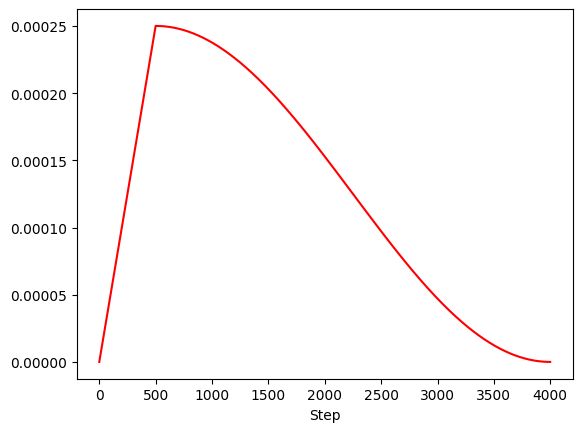

In [ ]:
import matplotlib.pyplot as plt

# 학습률 추이 계산
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# 결과 시각화
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [ ]:
# 실제 모델 생성

pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 enc_tokens (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 segments (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 bert (BERT)                 ((None, 256),                4485632   ['enc_tokens[0][0]',          
                              (None, None, 8007))                    'segments[0][0]']            
                                                                                                  
 pooled_nsp (PooledOutput)   (None, 2)                    66304     ['bert[0][0]']          

### 하이퍼 파라미터

In [ ]:
# 에포크 및 배치 크기
epochs = 10
batch_size = 64

# 훈련 스텝 및 학습율, 최적화 도구 지정
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [ ]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)

# train
history = pre_train_model.fit(
    x=pre_train_inputs,
    y=pre_train_labels,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights]
)

Epoch 1/10
2000/2000 [==============================] - ETA: 0s - loss: 19.5980 - nsp_loss: 0.6463 - mlm_loss: 18.9517 - nsp_acc: 0.6041 - mlm_lm_acc: 0.1100
Epoch 1: mlm_lm_acc improved from -inf to 0.11003, saving model to bert_pre_train.hdf5
2000/2000 [==============================] - 264s 125ms/step - loss: 19.5980 - nsp_loss: 0.6463 - mlm_loss: 18.9517 - nsp_acc: 0.6041 - mlm_lm_acc: 0.1100
Epoch 2/10
2000/2000 [==============================] - ETA: 0s - loss: 17.5279 - nsp_loss: 0.6097 - mlm_loss: 16.9182 - nsp_acc: 0.6514 - mlm_lm_acc: 0.1295
Epoch 2: mlm_lm_acc improved from 0.11003 to 0.12946, saving model to bert_pre_train.hdf5
2000/2000 [==============================] - 253s 126ms/step - loss: 17.5279 - nsp_loss: 0.6097 - mlm_loss: 16.9182 - nsp_acc: 0.6514 - mlm_lm_acc: 0.1295
Epoch 3/10
2000/2000 [==============================] - ETA: 0s - loss: 16.1378 - nsp_loss: 0.5988 - mlm_loss: 15.5390 - nsp_acc: 0.6626 - mlm_lm_acc: 0.1489
Epoch 3: mlm_lm_acc improved from 0.129

## 학습과정 시각화

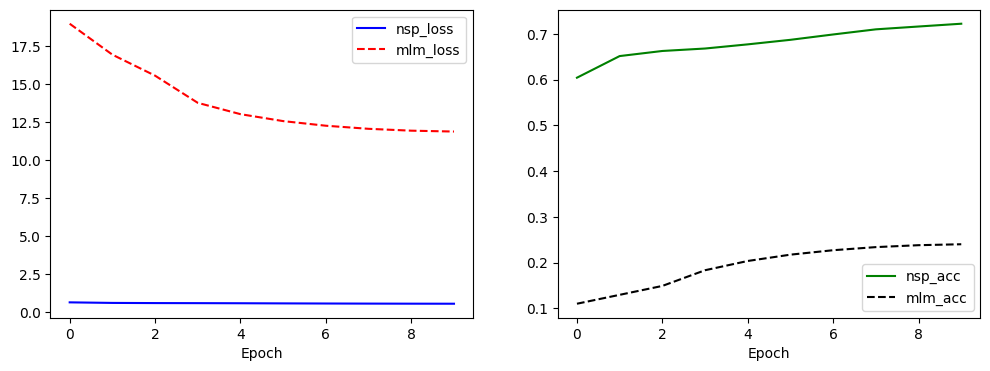

In [ ]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()